In [ ]:
# using dataframes stored in /dfs, visualize connectivity as a heatmap

In [1]:
# import packages
import pandas as pd
import numpy as np

from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean

from caveclient import CAVEclient
import os

/Users/ellenlesser/Desktop/code/Lesser_eLife_2025/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# open postsynaptic connectivity table of left admn sensory neurons
full_df = pd.read_pickle('dfs/sn_connectivity.pkl')
full_df.head()

id                          created  superceded_id valid  score  \
0  42130502 2022-11-17 14:28:59.843347+00:00            NaN     t     15   
1  42130504 2022-11-17 14:28:59.843347+00:00            NaN     t     33   
2   3803893 2022-11-17 14:28:59.843347+00:00            NaN     t     45   
3   3803897 2022-11-17 14:28:59.843347+00:00            NaN     t     72   
4   9188821 2022-11-17 14:28:59.843347+00:00            NaN     t    124   

   pre_pt_supervoxel_id      pre_pt_root_id  post_pt_supervoxel_id  \
0     72835979886907962  648518346488448078      72835979886902776   
1     72906348631059251  648518346480864602      72835979886889926   
2     73117799534815300  648518346502391366      73117799534818680   
3     73117799534637778  648518346488758877      73117799534635382   
4     72765405856699418  648518346478162157      72765405856692115   

      post_pt_root_id        pre_pt_position       post_pt_position  
0  648518346475073189   [24543, 130783, 736]   [24571, 130783, 737]  
1  648518346491587270   [24597, 130805, 734]   [24575, 130795, 734]  
2  648518346496198668  [31479, 140871, 2812]  [31459, 140893, 2812]  
3  648518346496198668  [31437, 140481, 2744]  [31467, 140495, 2743]  
4  648518346496198668  [21851, 124725, 2391]  [21879, 124703, 2391]

In [43]:
# limit to connections with five synapses
# long - 2 min 12 sec

# function from tuthill-lab/Lesser_Azevedo_2023
def group_and_count_inputs(df, thresh):

    # count the number of synapses between pairs of pre and post synaptic inputs
    syn_in_conn=df.groupby(['pre_pt_root_id','post_pt_root_id']).transform(len)['id']
    # save this result in a new column and reorder the index
    df['syn_in_conn']=syn_in_conn
    df = df[['id', 'pre_pt_root_id','post_pt_root_id','score','syn_in_conn']].sort_values('syn_in_conn', ascending=False).reset_index()

    # Filter out small synapses between pairs of neurons and now print the shape
    df = df[df['syn_in_conn']>=thresh]
    # print(df.shape)
    return df

df = group_and_count_inputs(full_df,thresh=5)

In [44]:
# convert to an adjacency matrix
adj = pd.crosstab(df.pre_pt_root_id,df.post_pt_root_id).reset_index()
adj

post_pt_root_id      pre_pt_root_id  648518346342221942  648518346342697252  \
0                648518346465961520                   0                   0   
1                648518346467538439                   0                   0   
2                648518346470385918                   0                   0   
3                648518346472382217                   0                   0   
4                648518346472435465                   0                   0   
..                              ...                 ...                 ...   
121              648518346515083079                   0                   0   
122              648518346515403345                   0                   0   
123              648518346517185573                   0                   0   
124              648518346523995653                   0                   0   
125              648518346526399447                   0                   0   

post_pt_root_id  648518346343366314  648518346343481009  648518346343897574  \
0                                 0                   0                   0   
1                                 0                   0                   0   
2                                 0                   0                   0   
3                                 0                   0                   0   
4                                 0                   0                   0   
..                              ...                 ...                 ...   
121                               0                   0                   0   
122                               0                   0                   0   
123                               0                   0                   0   
124                               0                   0                   0   
125                               0                   0                   0   

post_pt_root_id  648518346344121060  648518346344573532  648518346345423031  \
0                                 0                   0                   0   
1                                 0                   0                   0   
2                                 0                   0                   0   
3                                 0                   0                   0   
4                                 0                   0                   0   
..                              ...                 ...                 ...   
121                               0                   0                   0   
122                               0                   0                   0   
123                               0                   0                   0   
124                               0                   0                   0   
125                               0                   0                   0   

post_pt_root_id  648518346345464936  ...  648518346524374021  \
0                                 0  ...                   0   
1                                 0  ...                   0   
2                                 0  ...                   0   
3                                 0  ...                   0   
4                                 0  ...                   0   
..                              ...  ...                 ...   
121                               0  ...                   0   
122                               0  ...                   0   
123                               0  ...                   0   
124                               0  ...                  17   
125                               0  ...                   0   

post_pt_root_id  648518346526162391  648518346526231767  648518346526264535  \
0                                 0                   0                   0   
1                                 0                   0                   0   
2                                 0                   0                   0   
3                                 0                   0             

In [45]:
# Next, order everything according to how you want to plot it.
# presynaptic neurons by their postsynaptic similarity:
# postsynaptic similarity is according to clusters previously determine through cosine similarity and agglomerative clustering and saved as part of the sn table. 
# similarity is also derived in the similarity.ipynb file in this folder
# postsynaptic neurons will be ordered first by their cell class (motor, ascending, etc) and then by which "cluster" they get the most input from

In [46]:
# for ease later on, rename clusters e.g. cluster_1 should be cluster_01 so that it comes before cluster_02

number_dict = {
  "cluster_1": "cluster_01",
  "cluster_2": "cluster_02",
  "cluster_3": "cluster_03",
  "cluster_4": "cluster_04",
  "cluster_5": "cluster_05",
  "cluster_6": "cluster_06",
  "cluster_7": "cluster_07",
  "cluster_8": "cluster_08",
  "cluster_9": "cluster_09",
}

In [47]:
# to order the postsynaptic cells by cell class and amount of input from each cluster

# add a column for which cluster gives the most input

# create a dictionary of sensory neurons and the cluster they belong to
sn_table = pd.read_pickle('dfs/sn_table.pkl')
sn_table["classification_system"].replace(number_dict, inplace=True)
dict_sn_cluster = dict(zip(sn_table.pt_root_id, sn_table.classification_system))

# make a copy of the adjacency matrix to collapse into sensory clusters
adj_collapse = adj.copy()
adj_collapse.pre_pt_root_id = adj_collapse.pre_pt_root_id.map(dict_sn_cluster)
adj_collapse = adj_collapse.set_index('pre_pt_root_id', drop=True)
adj_collapse

# table of each postsynaptic neuron and its top cluster of input
post_max_df = pd.DataFrame(adj_collapse.groupby('pre_pt_root_id').sum().idxmax().rename_axis('post_root_id').reset_index(name='max_cluster'))
post_max_df = post_max_df.iloc[:-1,:]

# add a column for the sum
post_max_df['max_syn'] = adj_collapse.groupby('pre_pt_root_id').sum().max()[:-1].astype(int).to_list()

# rename post_class names to alphebatize easily...
class_dict = {
  "local": "c_intrinsic",
  "intrinsic": "c_intrinsic",
  "sensory": "b_sensory",
  "ascending": "d_ascending",
  "local_intersegmental": "c_intrinsic",
  "mn": "a_motor",
}

# add a column for cell type
post_table = pd.read_pickle('dfs/post_wing_table.pkl')
post_table["classification_system"].replace(class_dict, inplace=True)
dict_post_class = dict(zip(post_table.pt_root_id, post_table.classification_system))
post_max_df['post_class'] = post_max_df.post_root_id.map(dict_post_class)

# remove nan class neurons: this means that its a lesser partner, only plot those that have been proofread which accounts for >80% of total output
post_max_df = post_max_df.dropna(subset=['post_class'])

# create a list of ordered post_root_id: by max cluster, then max_syn, then post_class
post_order = post_max_df.sort_values(['post_class', 'max_cluster', 'max_syn'], ascending=[True, True, False]).iloc[3:,:].post_root_id.to_list() # removed the one descending, efferent, and unproofed neuron

adj_ordered = adj.set_index('pre_pt_root_id')[post_order]
adj_ordered['sn_cluster'] = adj_ordered.index.map(dict_sn_cluster)

/var/folders/kc/3ksx1s8x04xcd7r2v8zsqqtm0000gn/T/ipykernel_80936/221041523.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sn_table["classification_system"].replace(number_dict, inplace=True)
/var/folders/kc/3ksx1s8x04xcd7r2v8zsqqtm0000gn/T/ipykernel_80936/221041523.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are 

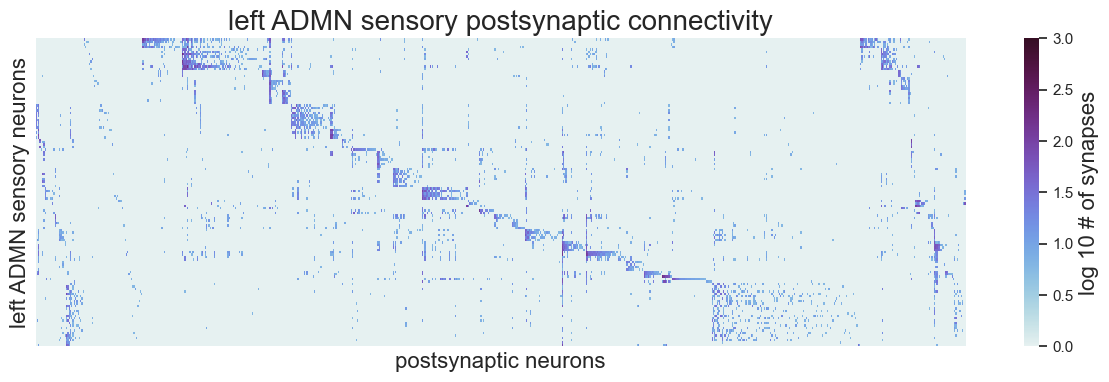

In [48]:
# visualize
source = adj_ordered.sort_values(by='sn_cluster')

fig = plt.figure(1, figsize = [15,4])
sns.set(font_scale= 1)
cmap = cmocean.cm.dense

log_values = np.log10(source.iloc[:,:-1] +1)
# sn_ids = source['sn_cluster'].to_list()
# post_ids = source.columns.to_list()
ax = sns.heatmap(log_values, vmin = 0, vmax = 3, xticklabels='', yticklabels='', cmap = cmap)

ax.xaxis.set_ticks_position('bottom')
cbar = ax.collections[0].colorbar
plt.title('left ADMN sensory postsynaptic connectivity', size = 20)
cbar.set_label(label = 'log 10 # of synapses', size=16)
plt.xlabel('postsynaptic neurons', size = 16)
plt.ylabel('left ADMN sensory neurons', size = 16)
# # plt.savefig('../leftadmn_connmat.eps', format='eps', bbox_inches='tight')

plt.show()

In [49]:
# number of neurons per class
post_max_df.post_class.value_counts()

post_class
c_intrinsic    565
d_ascending     81
b_sensory       46
a_motor         41
descending       1
efferent         1
Name: count, dtype: int64

In [ ]:
# number of synapses per class
post_max_df[['post_class','max_syn']].groupby('post_class').sum()

max_syn
post_class          
a_motor         3417
b_sensory        421
c_intrinsic    25359
d_ascending     5228
descending         9
efferent          61